In [1]:
%reload_ext autoreload
%autoreload 2
import sys
import platform
import os
import uncerteval
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scp
%matplotlib inline
from uncerteval import StandardizerByTrainSet, DfDataProvider, CompletePoolingModel, Jump3rDataProvider
from uncerteval import ModelFitter, get_plot_method, NoPoolingModel, MultilevelLassoModel
import numpyro
import jax.numpy as jnp
import arviz as az
from copy import deepcopy
import numpy as np

/home/jdorn/code/workload-uncertainty-learning/wluncert/jupyer-venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Scenarios for Multilevel Models

# Workload Artificial

Idee:
 - Workload hat
   - eine Länge
   - ein binäres Feature `mono` 
 - Software hat
   - 1 Option `lin`, deren Einfluss linear mit der Länge skaliert
   - 1 Option `const`, die WL-unabhängigen Einfluss hat
   - 1 Option `switch`, skaliert, aber keinen Einfluss hat durch `mono` 
   - 1 irrelevante Option `irr`

In [2]:
def oracle(lin, const, switch, irr, wl_length, wl_mono):
    base = 1
    infl_lin = 0.2 * wl_length
    infl_const = 2
    infl_switch = 0.1 * wl_length if not wl_mono else 0.0
    infl_irr = 0.01
    perf = base + infl_lin * lin + infl_const * const + infl_switch * switch + infl_irr * irr
    return perf

In [3]:
def noisy(sd_rel, x):
    return scp.stats.norm(x,sd_rel*x).rvs()

## Configurations

In [4]:
option_names = "lin", "const", "switch", "irr"
option_values = list(itertools.product([1,0], repeat=len(option_names)))
option_values

[(1, 1, 1, 1),
 (1, 1, 1, 0),
 (1, 1, 0, 1),
 (1, 1, 0, 0),
 (1, 0, 1, 1),
 (1, 0, 1, 0),
 (1, 0, 0, 1),
 (1, 0, 0, 0),
 (0, 1, 1, 1),
 (0, 1, 1, 0),
 (0, 1, 0, 1),
 (0, 1, 0, 0),
 (0, 0, 1, 1),
 (0, 0, 1, 0),
 (0, 0, 0, 1),
 (0, 0, 0, 0)]

## Workloads

In [5]:
wl_feature_names = "length", "mono"
lengths = 1, 10, 50
mono = True, False

In [6]:
wl_features = list( (l, m) for l in lengths for m in mono)
wl_features

[(1, True), (1, False), (10, True), (10, False), (50, True), (50, False)]

In [7]:
X = [[*opts, length, mono, f"{length}_{mono}"] for opts in option_values for length, mono in wl_features]
X

[[1, 1, 1, 1, 1, True, '1_True'],
 [1, 1, 1, 1, 1, False, '1_False'],
 [1, 1, 1, 1, 10, True, '10_True'],
 [1, 1, 1, 1, 10, False, '10_False'],
 [1, 1, 1, 1, 50, True, '50_True'],
 [1, 1, 1, 1, 50, False, '50_False'],
 [1, 1, 1, 0, 1, True, '1_True'],
 [1, 1, 1, 0, 1, False, '1_False'],
 [1, 1, 1, 0, 10, True, '10_True'],
 [1, 1, 1, 0, 10, False, '10_False'],
 [1, 1, 1, 0, 50, True, '50_True'],
 [1, 1, 1, 0, 50, False, '50_False'],
 [1, 1, 0, 1, 1, True, '1_True'],
 [1, 1, 0, 1, 1, False, '1_False'],
 [1, 1, 0, 1, 10, True, '10_True'],
 [1, 1, 0, 1, 10, False, '10_False'],
 [1, 1, 0, 1, 50, True, '50_True'],
 [1, 1, 0, 1, 50, False, '50_False'],
 [1, 1, 0, 0, 1, True, '1_True'],
 [1, 1, 0, 0, 1, False, '1_False'],
 [1, 1, 0, 0, 10, True, '10_True'],
 [1, 1, 0, 0, 10, False, '10_False'],
 [1, 1, 0, 0, 50, True, '50_True'],
 [1, 1, 0, 0, 50, False, '50_False'],
 [1, 0, 1, 1, 1, True, '1_True'],
 [1, 0, 1, 1, 1, False, '1_False'],
 [1, 0, 1, 1, 10, True, '10_True'],
 [1, 0, 1, 1, 10, Fals

## Training data

In [8]:
y = [noisy(0.01, oracle(*features[:-1])) for features in X]
y

[3.2366415692155566,
 3.3131151750337966,
 5.0112723949113,
 5.944353309959731,
 13.140919119181197,
 17.95190659603772,
 3.2175247092868395,
 3.352269883095245,
 4.98215965369494,
 5.990750244351583,
 12.880360072419482,
 18.225151315376777,
 3.2410772246823223,
 3.2280799478306332,
 4.895625271589261,
 5.01672895690887,
 13.03701643421857,
 12.850056764844156,
 3.203413252797587,
 3.191345392308606,
 4.9443911461873675,
 4.98703315957986,
 13.10980334314955,
 13.06565927284227,
 1.2086753111006865,
 1.3065011779050664,
 3.00940806675051,
 3.920277642594524,
 10.893340946415856,
 16.050694080741366,
 1.2081536046285153,
 1.2802904676273417,
 3.006626651063243,
 3.9960711457009546,
 10.990622832794246,
 15.767829947604403,
 1.2191887047994077,
 1.2235934783755467,
 3.033705337152552,
 2.980258905804773,
 11.081756437337207,
 11.07821525592285,
 1.215821222026676,
 1.1996419380860142,
 2.980163216155582,
 3.015111436997748,
 11.018882363534548,
 10.990628617775615,
 2.9514847443699614,


In [9]:
pop_tups = [(*x,  y) for x, y in zip(X, y)]
pop_df = pd.DataFrame(pop_tups, columns=[*option_names, *wl_feature_names, "workload_id", "y"])
pop_df.head()

,lin,const,switch,irr,length,mono,workload_id,y
0,1,1,1,1,1,True,1_True,3.236642
1,1,1,1,1,1,False,1_False,3.313115
2,1,1,1,1,10,True,10_True,5.011272
3,1,1,1,1,10,False,10_False,5.944353
4,1,1,1,1,50,True,50_True,13.140919


In [10]:
pop_df = pop_df.drop(columns=["length", "mono"])

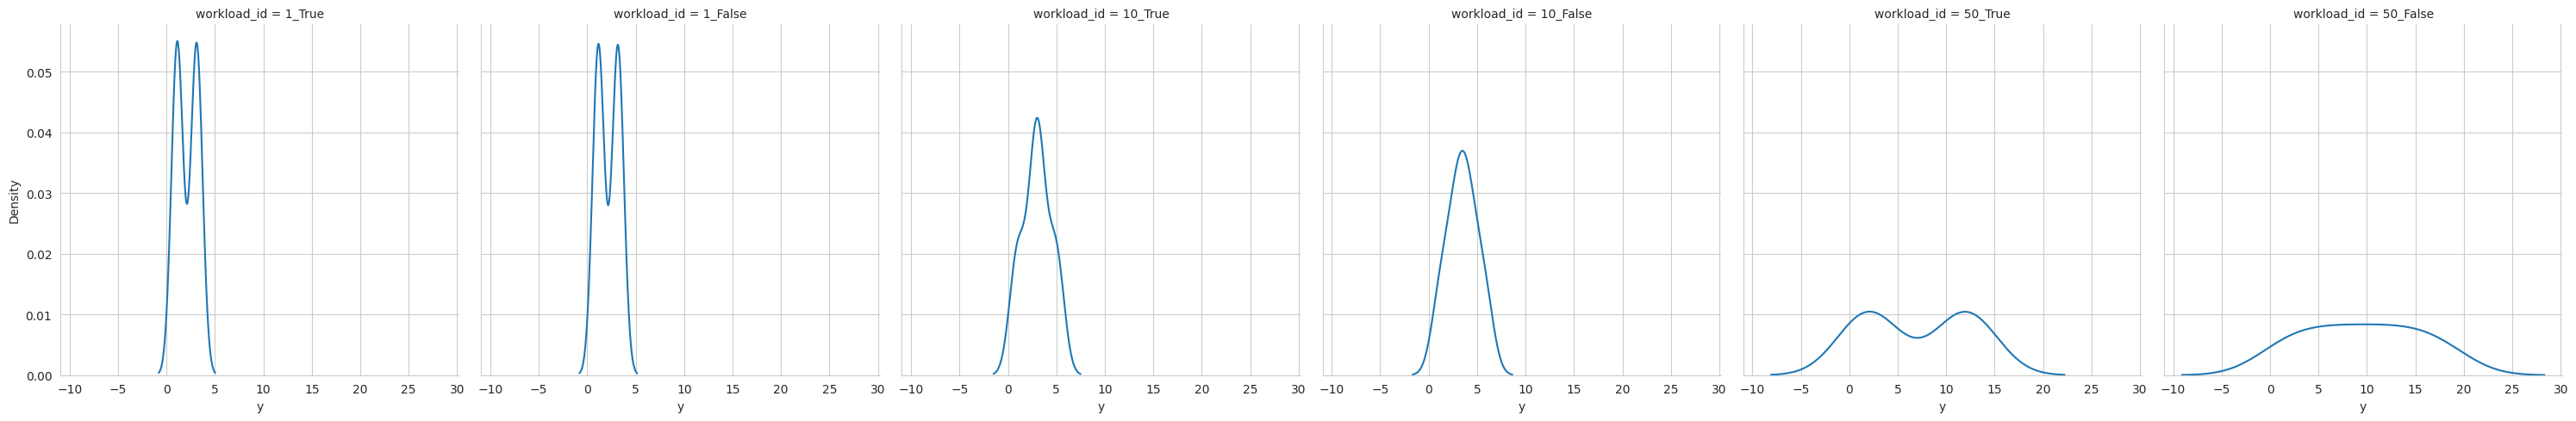

In [11]:
sns.displot(data = pop_df, x="y", kind="kde", col="workload_id",)

# Data Pre-Processing

## To normalize or not to normalize

Idea (von Stefan): normalize training data within a given workload to account for linear transfer

Disadvantage: standardized constant influences become smaller the higher the performance mean of a workload gets

In [24]:
standardizer = StandardizerByTrainSet(DfDataProvider("artificial", pop_df, train_ratio=0.5))

TypeError: super(type, obj): obj must be an instance or subtype of type

In [25]:
jump3rdf = pd.read_csv("training-data/jump3r.csv")
jump3rdf

,NoRes,NoReplayGain,Downmix,ReplayGainFast,MidSideStereo,Freeformat,Mono,DualChannels,Stereo,CRC,...,time,max-resident-size,Resampling,ABR,CBR,Lowpass,Highpass,LowpassWidth,HighpassWidth,VBRRange
0,False,True,False,False,False,False,False,True,False,False,...,16.15,412216,44,8,8,5000,20000,1000,1000,0
1,False,True,False,False,False,False,False,True,False,False,...,3.64,524724,44,8,8,5000,20000,1000,1000,0
2,False,True,False,False,False,False,False,True,False,False,...,6.55,428676,44,8,8,5000,20000,1000,1000,0
3,False,True,False,False,False,False,False,True,False,False,...,2.29,415520,44,8,8,5000,20000,1000,1000,0
4,False,True,False,False,False,False,False,True,False,False,...,7.64,420776,44,8,8,5000,20000,1000,1000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25171,False,True,False,False,False,False,True,False,False,False,...,0.63,407796,8,160,8,5000,25000,1000,2000,0
25172,False,True,False,False,False,False,True,False,False,False,...,1.13,415748,8,160,8,5000,25000,1000,2000,0
25173,False,True,False,False,False,False,True,False,False,False,...,0.75,404340,8,160,8,5000,25000,1000,2000,0
25174,False,True,False,False,False,False,True,False,False,False,...,0.97,418392,8,160,8,5000,25000,1000,2000,0


In [26]:
Jump3rDataProvider(jump3rdf)

TypeError: super(type, obj): obj must be an instance or subtype of type

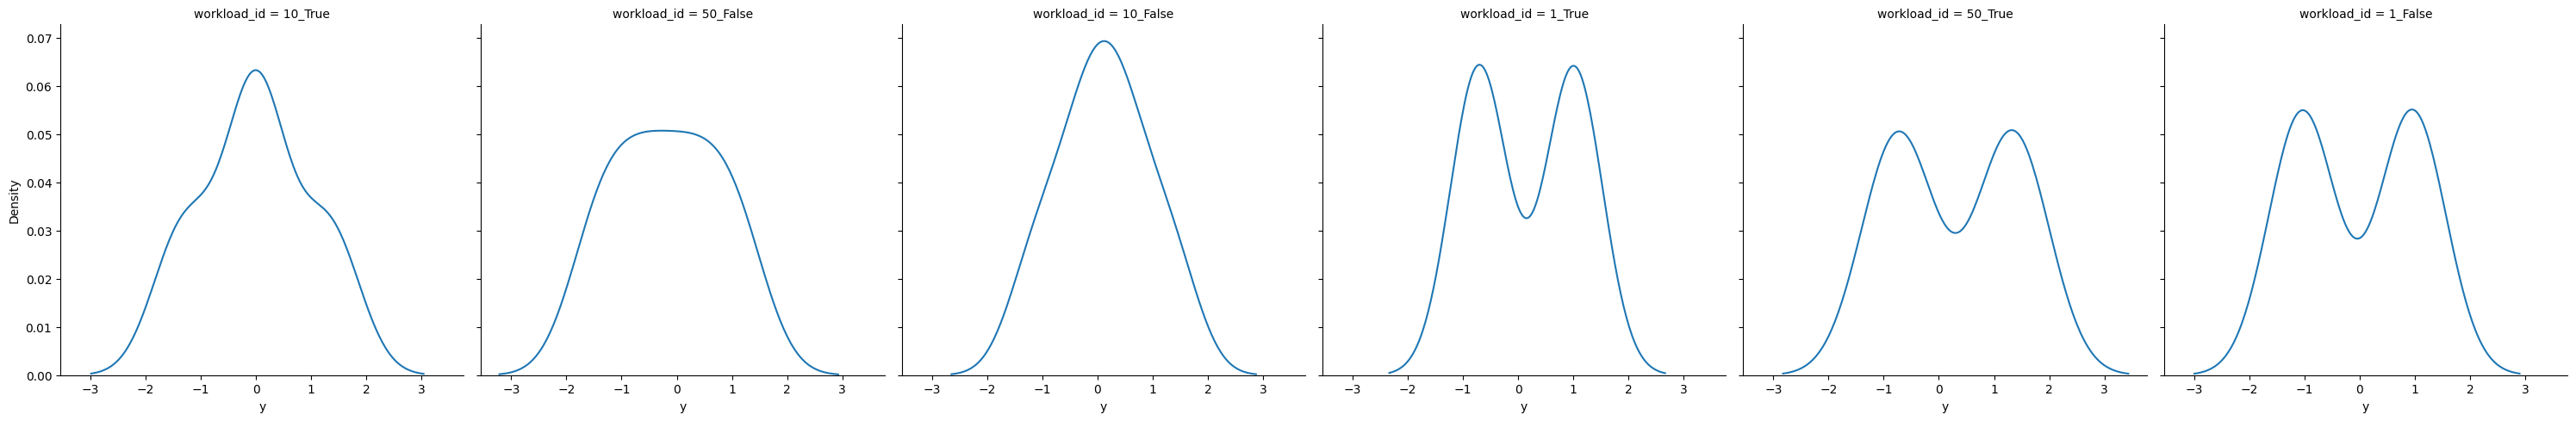

In [49]:
sns.displot(data = standardizer.data, x="y", kind="kde", col="workload_id",)

# Models

## Overview
1. complete pooling
2. no pooling
3. partial pooling

## Complete Pooling aka P4

```
with numpyro.plate("options", num_opts):
    rnd_influences = numpyro.sample("influences", self.prior_method_call(0, stddev), )

base = numpyro.sample("base", self.prior_method_call(0, stddev))
result_arr = jnp.multiply(data, rnd_influences)
result_arr = result_arr.sum(axis=1).ravel() + base
error_var = numpyro.sample("error", npdist.Exponential(1.0))

with numpyro.plate("data", result_arr.shape[0]):
    obs = numpyro.sample("observations", npdist.Normal(result_arr, error_var), obs=reference_y)
```            

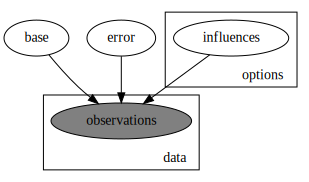

In [50]:
get_plot_method(CompletePoolingModel(), standardizer.data)()

## No Pooling aka For w in workloads: do P4

```
with numpyro.plate("options", num_opts):
    with numpyro.plate("workloads", n_workloads):
        rnd_influences = numpyro.sample("influences", self.prior_method_call(0, stddev), )

with numpyro.plate("workloads", n_workloads):
    bases = numpyro.sample("base", self.prior_method_call(0, stddev))

respective_influences = rnd_influences[workloads]
respective_bases = bases[workloads]
result_arr = jnp.multiply(data, respective_influences)
result_arr = result_arr.sum(axis=1).ravel() + respective_bases
error_var = numpyro.sample("error", npdist.Exponential(1.0))

with numpyro.plate("data", result_arr.shape[0]):
    obs = numpyro.sample("observations", npdist.Normal(result_arr, error_var), obs=reference_y)
```            

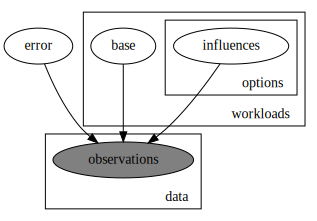

In [51]:
get_plot_method(NoPoolingModel(), standardizer.data)()

## Partial Pooling aka Multilevel Models

```
with numpyro.plate("options", num_opts):
    hyper_coef_means = numpyro.sample("abs-means-hyper", npdist.Laplace(0, stddev), )
    hyper_coef_stddevs = numpyro.sample("abs-stddevs-hyper", npdist.Exponential(stddev), )

hyper_base_mean = numpyro.sample("base mean hyperior", npdist.Laplace(0, stddev), )
hyper_base_stddev = numpyro.sample("base stddevs hyperior", npdist.Exponential(stddev), )

with numpyro.plate("options", num_opts):
    with numpyro.plate("workloads", n_workloads):
        rnd_influences = numpyro.sample("influences", npdist.Normal(hyper_coef_means, hyper_coef_stddevs), )

with numpyro.plate("workloads", n_workloads):
    bases = numpyro.sample("base", npdist.Normal(hyper_base_mean, hyper_base_stddev))

respective_influences = rnd_influences[workloads]
respective_bases = bases[workloads]
result_arr = jnp.multiply(data, respective_influences)
result_arr = result_arr.sum(axis=1).ravel() + respective_bases
prior_error_expt = 1.0
error_var = numpyro.sample("error", npdist.Exponential(prior_error_expt))

with numpyro.plate("data", result_arr.shape[0]):
    obs = numpyro.sample("observations", npdist.Normal(result_arr, error_var), obs=reference_y)
```            

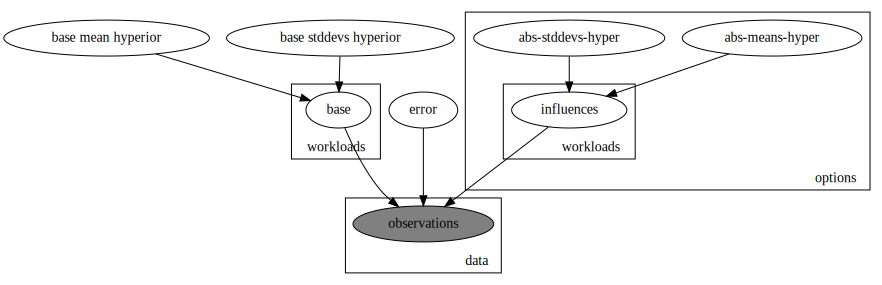

In [52]:
get_plot_method(MultilevelLassoModel(), standardizer.data)()

# Application

In [53]:
rnd=0

## Complete Pooling

In [54]:
%%capture
cpool_model = CompletePoolingModel()
fitter = ModelFitter(cpool_model)
fitter.fit(standardizer.data, rnd=rnd)

In [55]:
cpooling_az_d = fitter.get_arviz_data()
cpooling_az_d

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

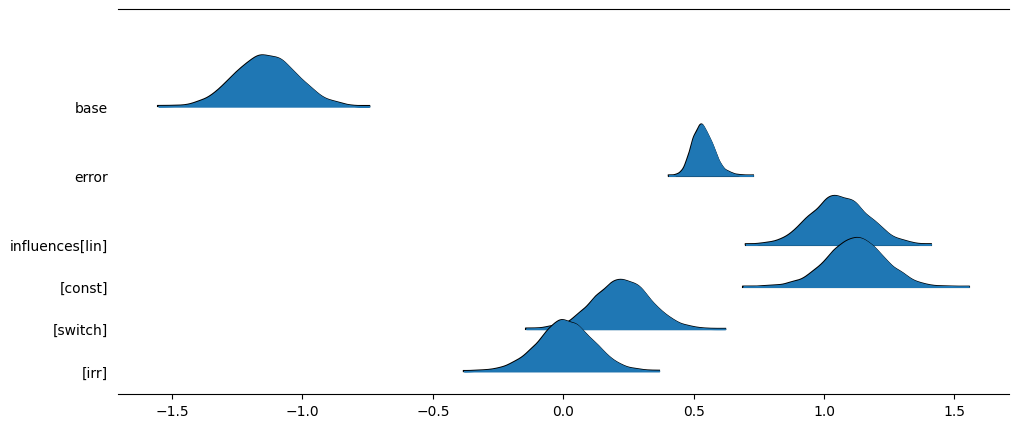

In [56]:
axes = az.plot_forest(
    cpooling_az_d,
    kind="ridgeplot",
    #var_names=["defs"],
    #linewidth=4,
    combined=True,
    ridgeplot_overlap=1.5,
    figsize=(11.5, 5),
    hdi_prob=0.9999,
)
plt.show()

In [57]:
az.loo(cpooling_az_d)

Computed from 4500 posterior samples and 96 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -78.99     7.16
p_loo        5.78        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       96  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [58]:
posterior_predictive_likelihoods = az.loo(cpooling_az_d, pointwise=True).loo_i

### Investigating surprising samples

-0.8228224118550619

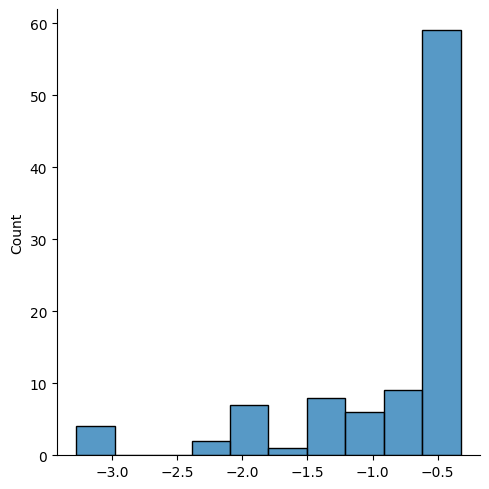

In [59]:
sns.displot(posterior_predictive_likelihoods)
complete_pooling_avg_lh = np.average(posterior_predictive_likelihoods)
complete_pooling_avg_lh

In [60]:
top_most_surprising_idx = np.argsort(list(posterior_predictive_likelihoods))[:3]
surprise_df = deepcopy(standardizer.data)
surprise_df["likelihood"] = posterior_predictive_likelihoods
standardizer.data.iloc[top_most_surprising_idx]

,lin,const,switch,irr,workload_id,y
46,1,0,0,0,50_True,1.161412
40,1,0,0,1,50_True,1.166830
65,0,1,0,1,50_False,-1.234733


In [82]:
def get_surprise_df(likelihoods, base_df):
    surprise_df = deepcopy(base_df)
    surprise_df["likelihood"] = likelihoods
    return surprise_df
surprise_df = get_surprise_df (posterior_predictive_likelihoods, standardizer.data)
surprise_df.corr()

,lin,const,switch,irr,y,likelihood
lin,1.000000e+00,1.850372e-17,0.000000e+00,1.387779e-17,0.569944,-0.044182
const,1.850372e-17,1.000000e+00,2.312965e-17,1.156482e-17,0.601821,0.017828
switch,0.000000e+00,2.312965e-17,1.000000e+00,-4.625929e-18,0.123648,0.086513
irr,1.387779e-17,1.156482e-17,-4.625929e-18,1.000000e+00,0.006763,-0.001857
y,5.699441e-01,6.018207e-01,1.236477e-01,6.762705e-03,1.000000,-0.015702
likelihood,-4.418246e-02,1.782824e-02,8.651296e-02,-1.856983e-03,-0.015702,1.000000


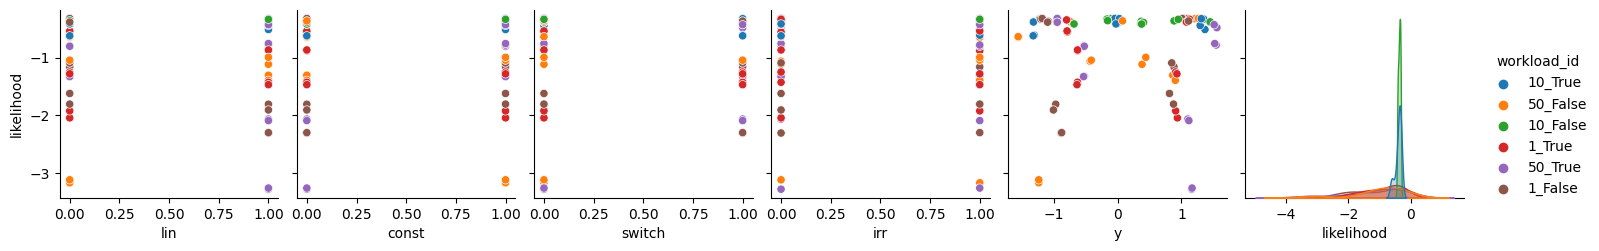

In [62]:
sns.pairplot(data=surprise_df, hue="workload_id", y_vars=["likelihood"])

## No Pooling

In [63]:
%%capture
nopool_model = NoPoolingModel()
no_pool_fitter = ModelFitter(nopool_model)
no_pool_fitter.fit(standardizer.data, rnd=rnd)

In [64]:
nopooling_az = no_pool_fitter.get_arviz_data()
nopooling_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

Text(0.5, 0.98, 'Simulating completely pooled model')

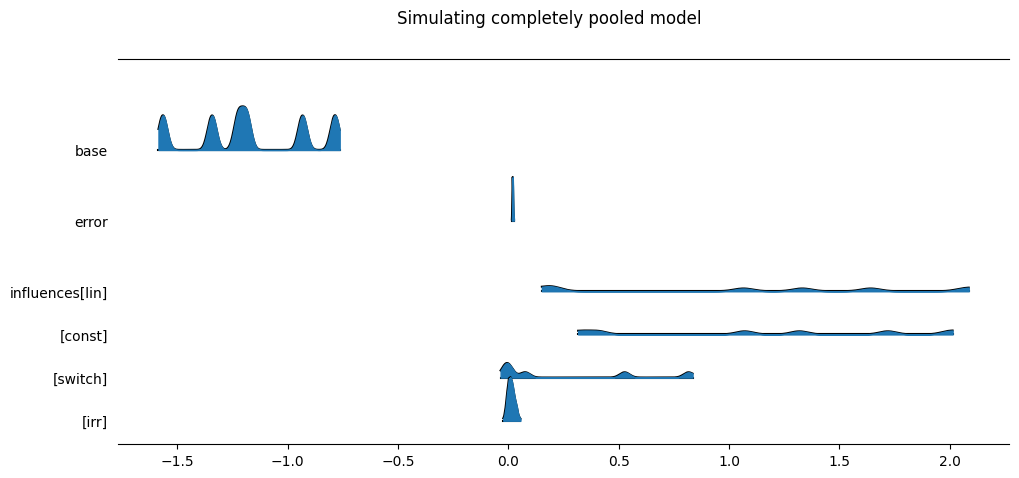

In [65]:
az.plot_forest(nopooling_az ,combined=True, combine_dims={"workloads"}, 
               var_names=["base", "error", "influences"], kind="ridgeplot", ridgeplot_overlap=1.25, hdi_prob=0.99, figsize=(11.5, 5),)
plt.suptitle("Simulating completely pooled model")

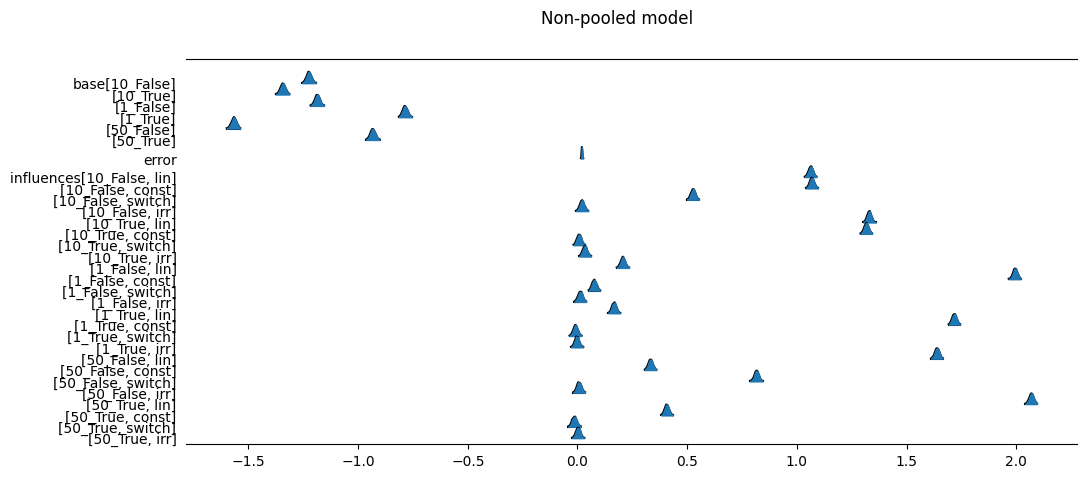

In [75]:
az.plot_forest(nopooling_az ,combined=True,
               var_names=["base", "error", "influences"], hdi_prob=0.99, figsize=(11.5, 5),
              kind="ridgeplot", ridgeplot_overlap=1.25,
              )
plt.suptitle("Non-pooled model")
plt.show()

In [80]:
az.loo(nopooling_az)

/home/jdorn/code/workload-uncertainty-learning/wluncert/jupyer-venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4500 posterior samples and 96 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   219.00     7.49
p_loo       28.32        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       76   79.2%
 (0.5, 0.7]   (ok)         17   17.7%
   (0.7, 1]   (bad)         3    3.1%
   (1, Inf)   (very bad)    0    0.0%

/home/jdorn/code/workload-uncertainty-learning/wluncert/jupyer-venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


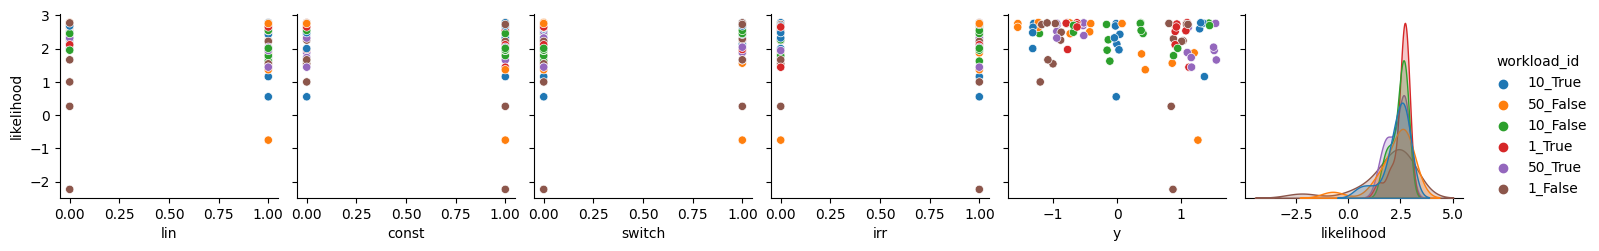

In [85]:
nopooling_posterior_predictive_likelihoods = az.loo(nopooling_az, pointwise=True).loo_i
nopooling_surprise_df = get_surprise_df(nopooling_posterior_predictive_likelihoods, standardizer.data)
sns.pairplot(data=nopooling_surprise_df, hue="workload_id", y_vars=["likelihood"])

## Partial Pooling

In [67]:
%%capture
multilevel_model = MultilevelLassoModel()
multilevel_fitter = ModelFitter(multilevel_model)
multilevel_fitter.fit(standardizer.data, rnd=rnd)

In [68]:
multilevel_az = multilevel_fitter.get_arviz_data()
multilevel_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

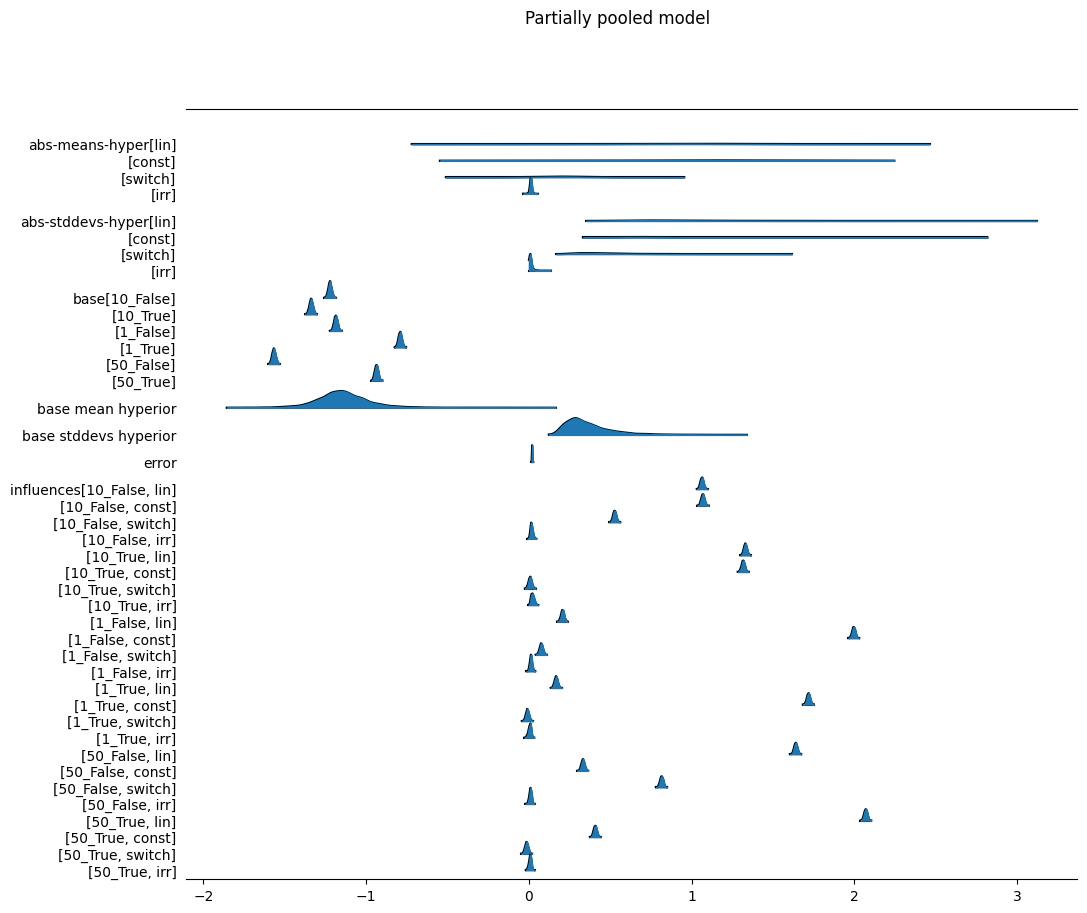

In [79]:
az.plot_forest(multilevel_az ,combined=True, #combine_dims={"workloads"}, 
               var_names=["~influences_decentered", "~base_decentered"],
               kind="ridgeplot", ridgeplot_overlap=1.25, 
               hdi_prob=0.999, figsize=(11.5, 10),)
plt.suptitle("Partially pooled model")
plt.show()

## Analysis

In [86]:
az.loo(multilevel_az)

/home/jdorn/code/workload-uncertainty-learning/wluncert/jupyer-venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4500 posterior samples and 96 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   220.37     7.63
p_loo       26.63        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       81   84.4%
 (0.5, 0.7]   (ok)         13   13.5%
   (0.7, 1]   (bad)         2    2.1%
   (1, Inf)   (very bad)    0    0.0%

/home/jdorn/code/workload-uncertainty-learning/wluncert/jupyer-venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


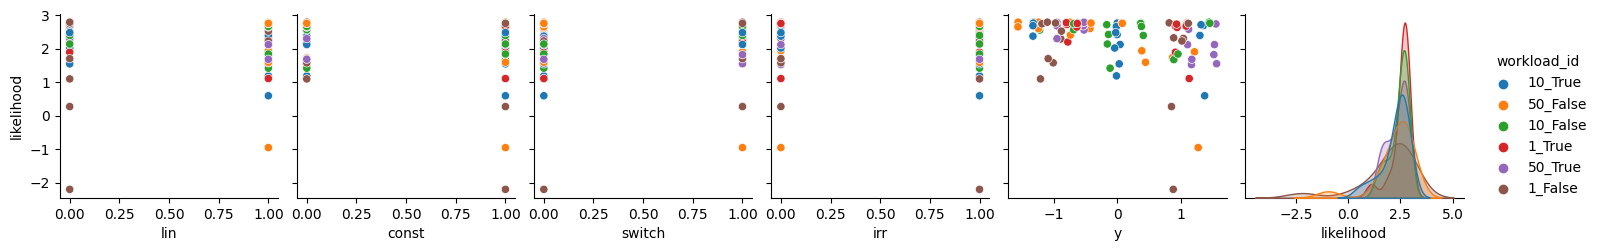

In [88]:
multilevel_posterior_predictive_likelihoods = az.loo(multilevel_az, pointwise=True).loo_i
multilevel_surprise_df = get_surprise_df(multilevel_posterior_predictive_likelihoods, standardizer.data)
sns.pairplot(data=multilevel_surprise_df, hue="workload_id", y_vars=["likelihood"])

In [74]:
multilevel_az.posterior["influences"].features

<xarray.DataArray 'features' (features: 4)>
array(['lin', 'const', 'switch', 'irr'], dtype='<U6')
Coordinates:
  * features  (features) <U6 'lin' 'const' 'switch' 'irr'

In [71]:
multilevel_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [2]:
def plot_feature_focus(feature_name: str, az_data, model_names=None, var_names=None):
    var_names = var_names if var_names is not None else ["options-means-hyper", "influences", ]
    coords = {"features": [feature_name]}
    az.plot_forest(az_data, combined=True,
                   var_names=var_names,
                   model_names=model_names,
                   kind="ridgeplot",
                   hdi_prob=0.999,
                   ridgeplot_overlap=3,
                   linewidth=3,
                   coords=coords)
    plt.suptitle(f"Option influence {feature_name}")
    plt.show()


# Scenarios

In [3]:
import pandas as pd
from sklearn.metrics import r2_score
import arviz as az
import numpy as np
from wluncert.uncerteval import DataProvider

In [4]:
def eval_r2(fitter:ModelFitter, data_provider:DataProvider):
    test = data_provider.get_test_data()
    test_y = list(test.iloc[:,-1])
    y_pred_scalar = fitter.predict(test)
    r2 = r2_score(test_y, y_pred_scalar)
    return r2


def fit_model(model, data_provider, rnd=0, num_warmup=1000):
    fitter = ModelFitter(model, num_warmup=num_warmup)
    train_data = data_provider.get_train_data()
    fitter.fit(train_data, rnd=rnd)
    return fitter

In [5]:
jump3rdf = pd.read_csv("training-data/jump3r.csv")

In [6]:
selected_wl = ["beethoven.wav", "single-channel.wav", "dual-channel.wav", "speech.wav"]
jump3rdf = jump3rdf[jump3rdf['workload'].isin(selected_wl)]

In [7]:
jprov = Jump3rDataProvider(jump3rdf, train_number_abs=500)
standardizer = StandardizerByTrainSet(jprov)
jump3rdf

,NoRes,NoReplayGain,Downmix,ReplayGainFast,MidSideStereo,Freeformat,Mono,DualChannels,Stereo,CRC,...,time,max-resident-size,Resampling,ABR,CBR,Lowpass,Highpass,LowpassWidth,HighpassWidth,VBRRange
0,False,True,False,False,False,False,False,True,False,False,...,16.15,412216,44,8,8,5000,20000,1000,1000,0
1,False,True,False,False,False,False,False,True,False,False,...,3.64,524724,44,8,8,5000,20000,1000,1000,0
3,False,True,False,False,False,False,False,True,False,False,...,2.29,415520,44,8,8,5000,20000,1000,1000,0
4,False,True,False,False,False,False,False,True,False,False,...,7.64,420776,44,8,8,5000,20000,1000,1000,0
6,False,False,False,False,False,False,False,False,False,False,...,23.92,642528,48,320,160,5000,20000,1000,1000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25168,False,False,True,False,True,False,False,False,False,False,...,4.56,600928,22,8,8,5000,25000,2000,2000,0
25170,False,True,False,False,False,False,True,False,False,False,...,2.30,582604,8,160,8,5000,25000,1000,2000,0
25171,False,True,False,False,False,False,True,False,False,False,...,0.63,407796,8,160,8,5000,25000,1000,2000,0
25173,False,True,False,False,False,False,True,False,False,False,...,0.75,404340,8,160,8,5000,25000,1000,2000,0


In [8]:
cpool_model = CompletePoolingModel()
cpool_fitter = fit_model(cpool_model, standardizer, num_warmup=3000)

INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-02-15 09:12:23.910 INFO    jax._src.lib.xla_bridge: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-02-15 09:12:23.911 INFO    jax._src.lib.xla_bridge: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-02-15 09:12:23.913 INFO    jax._src.lib.xla_bridge: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
202

In [9]:
nopool_model = NoPoolingModel()
nopool_fitter = fit_model(nopool_model, standardizer, num_warmup=3000)

Compiling.. :   0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

Running chain 1:   0%|          | 0/4500 [00:04<?, ?it/s]

Running chain 0:   5%|▌         | 225/4500 [00:10<01:47, 39.91it/s]

Running chain 1:   5%|▌         | 225/4500 [00:10<01:50, 38.66it/s]

Running chain 1:  10%|█         | 450/4500 [00:18<02:05, 32.26it/s]

Running chain 1:  15%|█▌        | 675/4500 [00:26<02:03, 30.92it/s]

Running chain 1:  20%|██        | 900/4500 [00:33<01:58, 30.44it/s]

Running chain 1:  25%|██▌       | 1125/4500 [00:41<01:52, 30.05it/s]

Running chain 1:  30%|███       | 1350/4500 [00:49<01:45, 29.76it/s]

Running chain 0:  40%|████      | 1800/4500 [01:04<01:32, 29.17it/s]

Running chain 1:  45%|████▌     | 2025/4500 [01:12<01:24, 29.27it/s]

Running chain 1:  50%|█████     | 2250/4500 [01:19<01:16, 29.44it/s]

Running chain 0:  55%|█████▌    | 2475/4500 [01:27<01:08, 29.40it/s]

Running chain 0:  60%|██████    | 2700/4500 [01:35<01:01, 29.26it/s]

Running 

In [10]:
multilevel_model = MultilevelLassoModel()
multilevel_fitter = fit_model(multilevel_model, standardizer, num_warmup=3000)

Compiling.. :   0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

Running chain 1:   0%|          | 0/4500 [00:07<?, ?it/s]

Running chain 0:   0%|          | 0/4500 [00:07<?, ?it/s]

Running chain 1:   5%|▌         | 225/4500 [00:14<02:14, 31.82it/s]

Running chain 1:  10%|█         | 450/4500 [00:24<02:32, 26.53it/s]

Running chain 1:  15%|█▌        | 675/4500 [00:33<02:31, 25.26it/s]

Running chain 1:  20%|██        | 900/4500 [00:43<02:24, 24.83it/s]

Running chain 1:  25%|██▌       | 1125/4500 [00:52<02:17, 24.50it/s]

Running chain 1:  30%|███       | 1350/4500 [01:01<02:09, 24.37it/s]

Running chain 1:  35%|███▌      | 1575/4500 [01:11<02:01, 24.12it/s]

Running chain 1:  40%|████      | 1800/4500 [01:20<01:53, 23.86it/s]

Running chain 1:  45%|████▌     | 2025/4500 [01:30<01:44, 23.77it/s]

Running chain 1:  50%|█████     | 2250/4500 [01:39<01:34, 23.86it/s]

Running chain 1:  55%|█████▌    | 2475/4500 [01:49<01:24, 23.89it/s]

Running chain 1:  

In [11]:
cpool_az = cpool_fitter.get_arviz_data()
nopool_az  = nopool_fitter.get_arviz_data()
multilevel_az = multilevel_fitter.get_arviz_data()

In [12]:
multilevel_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

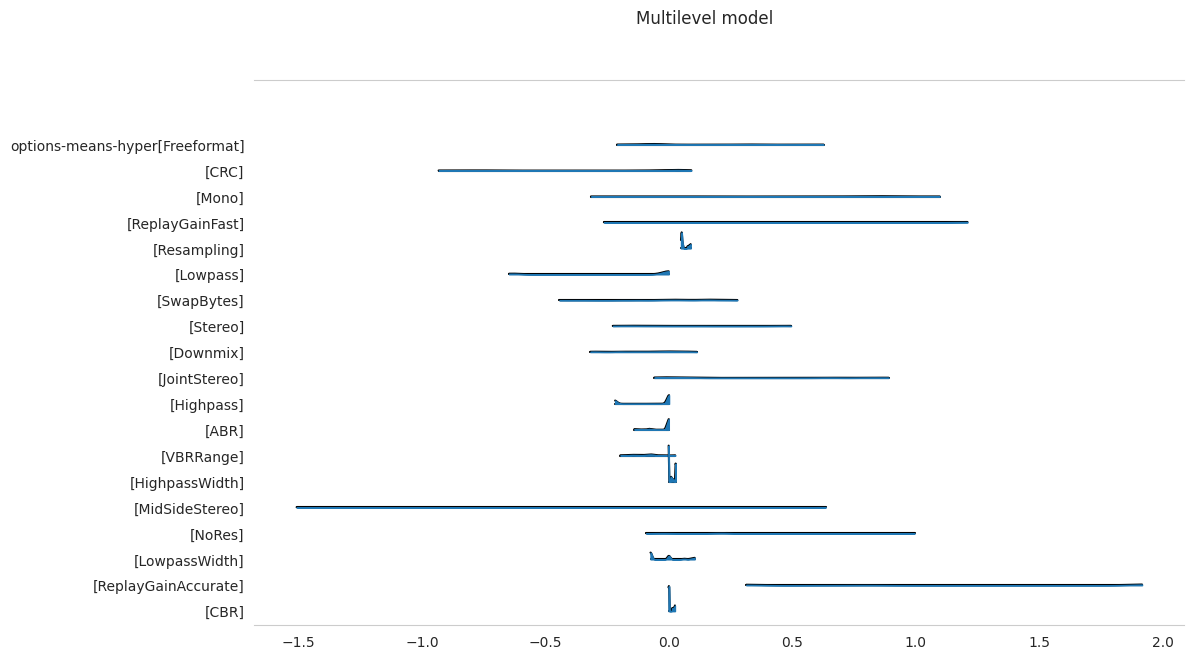

In [13]:
az.plot_forest(multilevel_az ,combined=True,
               var_names=["options-means-hyper"], hdi_prob=0.9, #figsize=(11.5, 18),
              kind="ridgeplot", ridgeplot_overlap=1.735,
              )
plt.suptitle("Multilevel model")
plt.show()

In [14]:
az.compare({"no-pooling":nopool_az, "complete-pooling": cpool_az, "multilevel": multilevel_az})

/home/jdorn/code/workload-uncertainty-learning/wluncert/jupyer-venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/jdorn/code/workload-uncertainty-learning/wluncert/jupyer-venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observa

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
no-pooling,0,-2.777592e+02,7.740949e+01,0.000000e+00,1.0,2.016255e+01,0.000000e+00,True,log
multilevel,1,-5.426899e+02,1.783978e+02,2.649307e+02,0.0,1.842376e+01,1.419541e+01,True,log
complete-pooling,2,-2.380711e+07,2.380662e+07,2.380683e+07,0.0,1.343963e+06,1.343963e+06,True,log


In [15]:
az.loo(cpool_az)

/home/jdorn/code/workload-uncertainty-learning/wluncert/jupyer-venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4500 posterior samples and 500 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -23807105.50  1343963.06
p_loo    23806615.34        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        1    0.2%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)  499   99.8%

In [16]:
multilevel_fitter.predict(standardizer.get_train_data(), n_samples=200, ci=0.5)

/home/jdorn/code/workload-uncertainty-learning/wluncert/uncerteval.py:682: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  y_pred = az.hdi(y_samples, hdi_prob=ci)


array([[-35440.6328125 ,   9120.14453125],
       [-34991.28515625,   9178.10449219],
       [-20054.10742188,  25717.40820312],
       [-14443.93945312,  22946.05273438],
       [-35026.73046875,   9146.76171875],
       [-34821.62890625,  18433.41601562],
       [-37976.79296875,  33136.6328125 ],
       [-24384.20898438,  20559.10546875],
       [-26627.20703125,  41259.6328125 ],
       [-37709.97265625,  26557.51171875],
       [-24701.6875    ,  20020.62304688],
       [-28067.78125   ,  27641.859375  ],
       [-33156.30859375,  16729.96679688],
       [-28320.19335938,  38651.5390625 ],
       [-14523.8046875 ,  22923.19921875],
       [-14865.54199219,  22805.3984375 ],
       [-34600.75      ,  36522.0625    ],
       [-14651.8828125 ,  22910.7890625 ],
       [-33225.140625  ,  21809.00976562],
       [-27715.02929688,  28107.91601562],
       [-14557.93164062,  22910.14257812],
       [-22374.58398438,  17305.40625   ],
       [-22883.6484375 ,  43126.234375  ],
       [-15

/home/jdorn/code/workload-uncertainty-learning/wluncert/jupyer-venv/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/jdorn/code/workload-uncertainty-learning/wluncert/jupyer-venv/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/jdorn/code/workload-uncertainty-learning/wluncert/jupyer-venv/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<AxesSubplot: title={'center': 'base'}>,
        <AxesSubplot: title={'center': 'base'}>],
       [<AxesSubplot: title={'center': 'error'}>,
        <AxesSubplot: title={'center': 'error'}>],
       [<AxesSubplot: title={'center': 'influences'}>,
        <AxesSubplot: title={'center': 'influences'}>]], dtype=object)

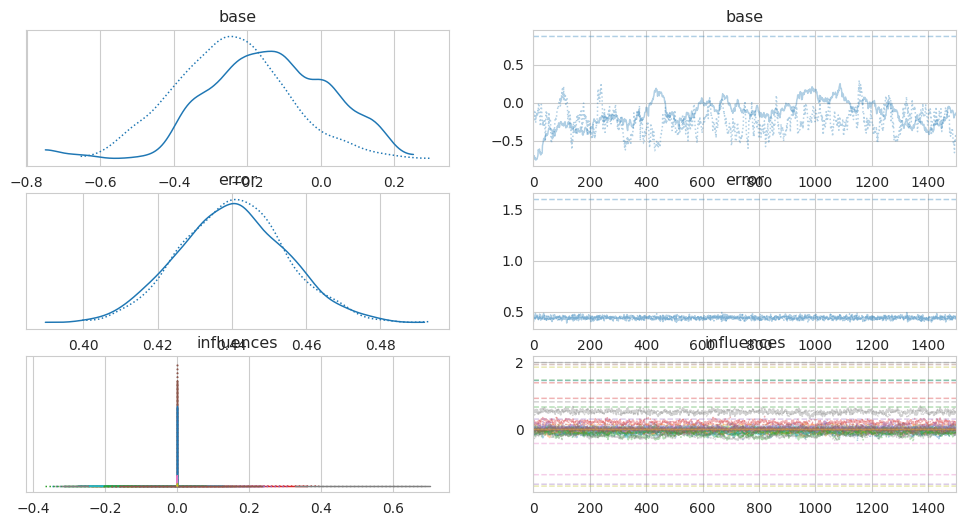

In [23]:
az.plot_trace(cpool_az)

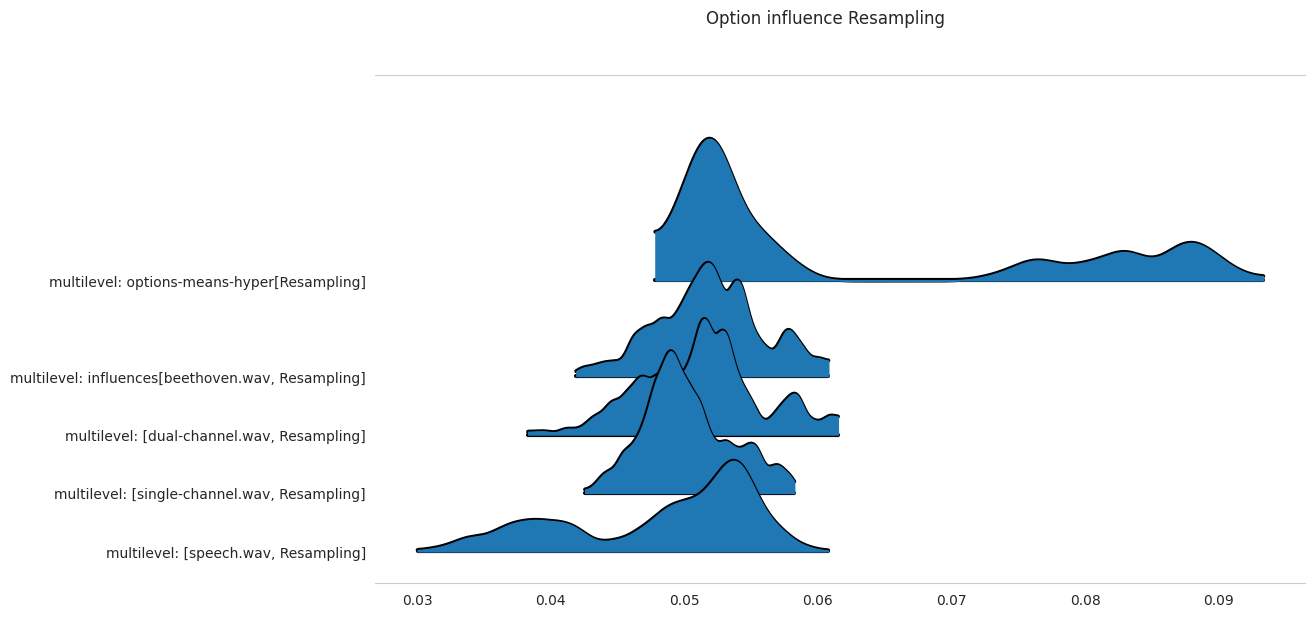

In [19]:
plot_feature_focus("Resampling", [multilevel_az], ["multilevel"])

# Refitting Models for AL

In [24]:
d = standardizer.get_train_data()

In [29]:
d_almost_no_wl_spech = deepcopy(d)
wl_map = d_almost_no_wl_spech["workload"] == "speech.wav"

In [41]:
wl_idx = np.nonzero(np.array(wl_map))[0]
wl_idx = wl_idx[1:]

In [42]:
d_almost_no_wl_spech.reset_index().drop(wl_idx)

,index,Freeformat,CRC,Mono,ReplayGainFast,Resampling,Lowpass,SwapBytes,Stereo,Downmix,...,ABR,VBRRange,HighpassWidth,MidSideStereo,NoRes,LowpassWidth,ReplayGainAccurate,CBR,workload,time
0,19480,False,True,False,False,22,5000,True,True,True,...,320,0,1000,False,True,1000,True,160,speech.wav,0.593023
2,4807,False,False,True,True,8,5000,False,False,False,...,160,0,1000,False,False,1000,False,8,dual-channel.wav,-1.408600
3,24259,False,True,False,False,8,5000,True,False,False,...,320,1,1000,True,False,1000,True,8,dual-channel.wav,-0.740871
5,14700,False,True,False,False,48,20000,True,False,False,...,8,0,1000,False,True,2000,True,8,beethoven.wav,1.418408
6,13533,False,True,False,False,44,10000,False,True,False,...,320,0,1000,False,False,2000,True,8,single-channel.wav,-0.095528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,23145,False,True,False,False,22,10000,True,True,True,...,320,0,2000,False,True,1000,True,8,single-channel.wav,-0.511003
494,21174,False,True,False,True,22,5000,False,True,False,...,8,0,1000,False,True,1000,False,8,beethoven.wav,-0.490863
495,13837,False,False,False,False,22,10000,True,True,False,...,320,1,1000,False,False,2000,True,8,dual-channel.wav,-0.589687
497,14767,False,False,False,True,22,5000,False,False,False,...,320,0,1000,False,False,1000,False,8,dual-channel.wav,-0.658980


In [43]:
d.iloc[wl_idx]

,Freeformat,CRC,Mono,ReplayGainFast,Resampling,Lowpass,SwapBytes,Stereo,Downmix,JointStereo,...,ABR,VBRRange,HighpassWidth,MidSideStereo,NoRes,LowpassWidth,ReplayGainAccurate,CBR,workload,time
23878,False,True,False,False,22,5000,True,False,False,True,...,320,1,1000,False,False,1000,True,8,speech.wav,0.527645
21802,False,True,False,True,8,5000,True,False,True,False,...,320,0,1000,False,False,1000,False,8,speech.wav,-1.226023
23032,False,False,False,False,22,5000,True,False,False,False,...,320,0,2000,True,False,2000,True,8,speech.wav,-0.314577
12094,True,True,False,False,8,20000,True,False,False,True,...,320,0,1000,False,True,2000,False,160,speech.wav,-1.399083
4786,False,False,False,True,22,5000,False,True,False,False,...,320,0,1000,False,False,1000,False,160,speech.wav,-0.479945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3244,False,True,False,True,8,5000,False,False,False,True,...,320,0,1000,False,False,1000,False,320,speech.wav,-1.072193
15490,True,True,False,True,22,5000,True,False,True,False,...,320,0,1000,False,True,1000,False,160,speech.wav,-0.514557
22402,False,True,False,True,22,10000,True,True,True,False,...,320,0,2000,False,True,1000,False,8,speech.wav,-0.749149
19684,False,True,False,True,44,5000,False,True,True,False,...,320,0,1000,False,False,1000,False,8,speech.wav,1.239111


In [47]:
def split_train_data_almost_by_wl(data_provider, workload, ):
    train_data = data_provider.get_train_data()
    d_almost_no_wl = deepcopy(d)
    wl_map = d_almost_no_wl["workload"] == workload
    wl_idx = np.nonzero(np.array(wl_map))[0]
    wl_idx = wl_idx[1:]
    d_almost_no_wl = d_almost_no_wl.reset_index().drop(wl_idx)
    d_worklad = d.iloc[wl_idx]
    return d_almost_no_wl, d_worklad

In [48]:
def fit_model_almoast_exclude_WL(model, data_provider, workload, rnd=0, num_warmup=1000, ):
    fitter = ModelFitter(model, num_warmup=num_warmup)
    d_almost_no_wl, d_wl = split_train_data_almost_by_wl(data_provider, workload)
    fitter.fit(d_almost_no_wl, rnd=rnd)
    return fitter

In [49]:
def refit_model_with_WL(model, data_provider, workload, rnd=0, num_warmup=1000, ):
    fitter = ModelFitter(model, num_warmup=num_warmup)
    d_almost_no_wl, d_wl = split_train_data_almost_by_wl(data_provider, workload)
    fitter.refit(d_wl, rnd=rnd)
    return fitter

In [ ]:
multilevel_model = MultilevelLassoModel()
multilevel_fitter = fit_model(multilevel_model, standardizer, num_warmup=3000)